In [3]:
import os
import numpy as np
from scipy.ndimage import laplace
from skimage.io import imread
import matplotlib.pyplot as plt

In [4]:
# pAAA 2023_11_28 Tweez pos 5
#log_params = {"A": 12.063403838846387, "mu_m": 0.020230378218499538, "lambda": 1.3282751030972482e-16}
#incubation_time = 7.58 * 60 * 60 # from Positions.xlsx

# pAAA 2023_11_30 Tweez pos 15
log_params = {"A": 11.364949076831643, "mu_m": 0.02570915482291693, "lambda": 10.42149277002458}
#incubation_time = 7.5833 * 60 * 60 # from Positions.xlsx
gomp_params = {"A": 86590.16997388891, "mu_m": 242.29351344003047, "lambda": 350.9260575006792}
incubation_time = 7.5833 * 60 * 60

# pAAA 2023_11_28 Tweez pos 1

def logistic_growth_rate(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    gr = 4 * mu_m * np.exp(4 * mu_m / A * (l - t) + 2) / (1 + np.exp(4 * mu_m / A * (l - t) + 2))**2
    return gr / 60

def logistic(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    log_B = A / (1 + np.exp(4 * mu_m / A * (l - t) + 2))
    return np.exp(log_B)

def gompertz(t, gomp_params):
    t = (t + incubation_time) / 60
    A = gomp_params['A']
    mu_m = gomp_params['mu_m']
    l = gomp_params['lambda']
    log_B = A * np.exp(-np.exp(mu_m * np.exp(1) / A * (l - t) + 1))
    return log_B

def gompertz_growth_rate(t, gomp_params):
    t = (t + incubation_time) / 60
    A = gomp_params['A']
    mu_m = gomp_params['mu_m']
    l = gomp_params['lambda']
    gr = mu_m * np.exp(np.exp(1) * mu_m * (l - t) / A - np.exp(np.exp(1) * mu_m * (l - t) / A + 1) + 2)
    return gr

In [4]:
#path_ext = '/Users/timrudge/Pictures/Analyzed files' # 
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
folder_results = 'results'
folder_velocity = 'velocity_data'

scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}

In [5]:
exp_date = '2023_11_30'
vector = 'pAAA'
#vector = 'pLPT107&pLPT41'
#vector = 'pLPT20&pLPT41'
#vector = 'pLPT119&pLPT41'

#scope_name = 'Ti scope'
scope_name = 'Tweez scope'
pos = 15

path_scope = os.path.join(path_ext, scope_name)
path = os.path.join(path_scope, exp_date)
path_results = os.path.join(path,folder_results, f"pos{pos}")
path_velocity = os.path.join(path,folder_velocity, f"pos{pos}")

fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
fname

'2023_11_30_10x_1.0x_pAAA_TiTweez_Pos15.ome.tif'

In [6]:
if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

In [29]:
edt = np.load(os.path.join(path_results,'edt.npy'))
#edt = edt[20:,:,:]
print(edt.shape)

(216, 1024, 1024)


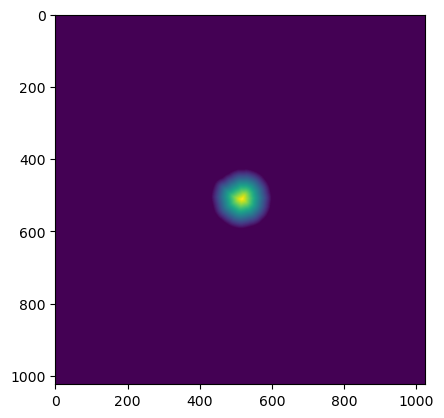

In [30]:
plt.imshow(edt[0,:,:])

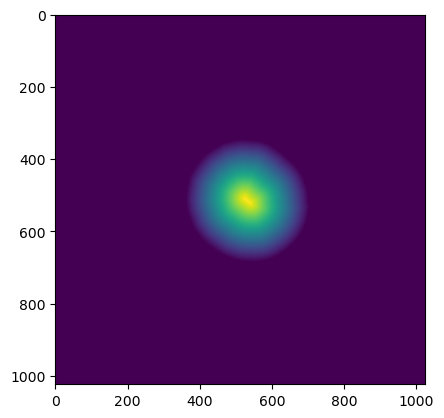

In [31]:
plt.imshow(edt[-1,:,:])

In [32]:
im = imread(os.path.join(path,fname))
im.shape

(216, 1024, 1024, 4)

In [33]:
im = imread(os.path.join(path,fname))
im.shape
#im = im.transpose([0,2,3,1])
#im = im[:,:,:,[2,3,4,1]]

(216, 1024, 1024, 4)

In [34]:
im = im[:,:,:,:ph_chn].astype(float)
print(im.shape)

(216, 1024, 1024, 3)


In [35]:
from scipy.ndimage import gaussian_filter

# Background correction
nt,nx,ny,nc = im.shape
bg = im[:,-256:,-256:,:].mean(axis=(1,2))
bgvar = im[:,-256:,-256:,:].var(axis=(1,2))

for t in range(nt):
    for c in range(nc):
        im[t,:,:,c] = gaussian_filter(im[t,:,:,c], 1) - bg[t,c]

im[im<0] = 0

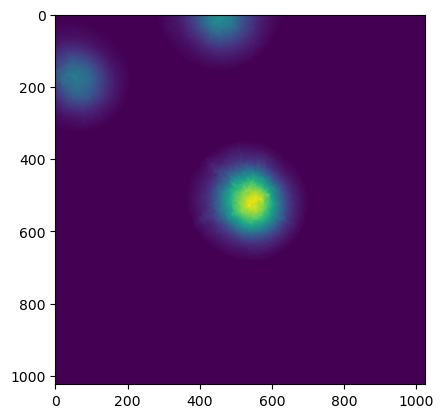

In [36]:
plt.imshow(im[-1,:,:,0])

In [37]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
h = maxy - miny
w = int(w//2) * 2
h = int(h//2) * 2

print(w,h)
pad = 128
crop_edt = np.zeros((nt,w+2*pad,h+2*pad))
crop_im = np.zeros((nt,w+2*pad,h+2*pad,3))
print(crop_edt.shape)

for t in range(nt):
    tedt = edt[t,:,:]
    tim = im[t,:,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())
    crop_edt[t,:,:] = tedt[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad]
    crop_im[t,:,:] = tim[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad,:]

336 338
(216, 592, 594)


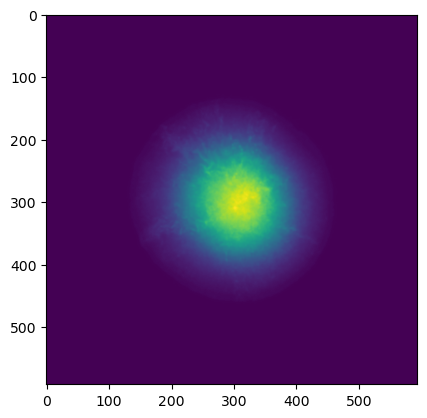

In [38]:
plt.imshow(crop_im[-1,:,:,0])

#### Diffusion

In [23]:
nt,nx,ny = crop_edt.shape
offset = incubation_time / 60 / 10
ntt = nt + int(offset)
crop_edt = np.zeros((ntt,nx,ny))
y,x = np.meshgrid(np.arange(ny), np.arange(nx))
cx,cy = nx/2, ny/2
R = np.sqrt((x-cx)**2 + (y-cy)**2)
area_all = np.zeros(ntt)
for t in range(ntt):
    area = logistic(t * 10 * 60 - offset * 10 * 60, log_params)
    area_all[t] = area
    #area = gompertz(t * 10 * 60 - offset * 10 * 60, gomp_params)
    radius = np.sqrt(area / np.pi)
    crop_edt[t,:,:] = radius - R
    tedt = crop_edt[t,:,:]
    tedt[tedt<0] = 0 
    crop_edt[t,:,:] = tedt
np.save(os.path.join(path_results,'diff_area_all.npy'),area_all)

NameError: name 'incubation_time' is not defined

In [17]:
def split_image_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width, channels = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size, channels))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for c in range(channels):
                for t in range(nt):
                    blocks[t, i, j, :, :, c] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size, c]
    return blocks

def split_edt_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for t in range(nt):
                blocks[t, i, j, :, :] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
    return blocks

edt_blocks = split_edt_into_blocks(crop_edt, 16)
im_blocks = split_image_into_blocks(crop_im, 16)
crop_edt_low = edt_blocks.mean(axis=(3,4))
crop_im_low = im_blocks.mean(axis=(3,4))
print(crop_im_low.shape)


(216, 37, 37, 3)


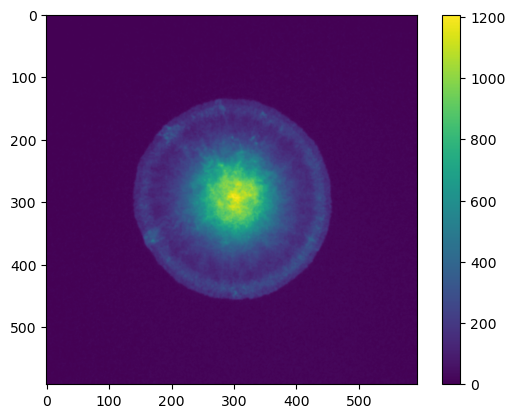

In [18]:
plt.imshow(crop_im[100,:,:,1])
plt.colorbar()

In [19]:
#from skimage.transform import downscale_local_mean

#print(crop_edt.shape)
#crop_edt_low = np.zeros((ntt,52,52))
#crop_im_low = np.zeros((nt,52,52,3))

#for t in range(ntt):
#    edt_low = downscale_local_mean(crop_edt[t,:,:], (16,16))
#    crop_edt_low[t,:,:] = edt_low

#for t in range(nt):
#    im_low = downscale_local_mean(crop_im[t,:,:], (16,16,1))
#    crop_im_low[t,:,:] = im_low

crop_edt = crop_edt_low
crop_im = crop_im_low
print(crop_edt.shape)
ntt,nx,ny = crop_edt.shape
nt,nx,ny,nc = crop_im.shape

crop_im[crop_edt[int(offset):,:,:]==0] = np.nan

(261, 37, 37)


In [20]:
np.save(os.path.join(path_results, 'diff_crop_edt.npy'), crop_edt)
np.save(os.path.join(path_results, 'diff_crop_im.npy'), crop_im)

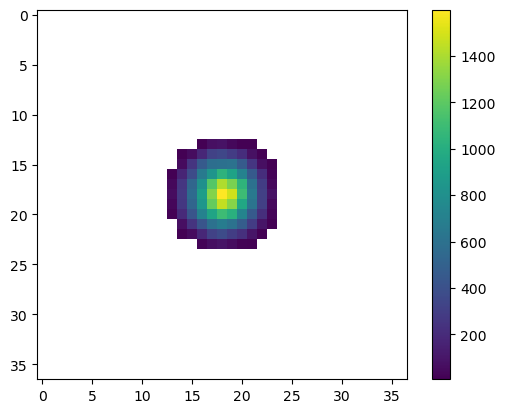

In [21]:
plt.imshow(crop_im[0,:,:,0])
plt.colorbar()

In [22]:
def dudt(u, t, tmask, phi, kappa, gamma0, gamma1, dx, t0):
    du = np.zeros((nx,ny))
    #du[tmask] += phi * 1 / (1 + np.exp((t - t0) / dt)) # * np.exp(-t * 1e-6)
    u = u.reshape((nx,ny))
    delu = laplace(u, mode='nearest')
    du += kappa * delu / dx / dx
    #du[tmask] -= gamma * u[tmask] * 1 / (1 + np.exp((t - t0) / dt))
    gr = logistic_growth_rate(t - offset * 10 * 60, log_params)
    #gr = gompertz_growth_rate(t - offset * 10 * 60, gomp_params)
    du[tmask] -= gamma0 * u[tmask] * gr
    return du.ravel()

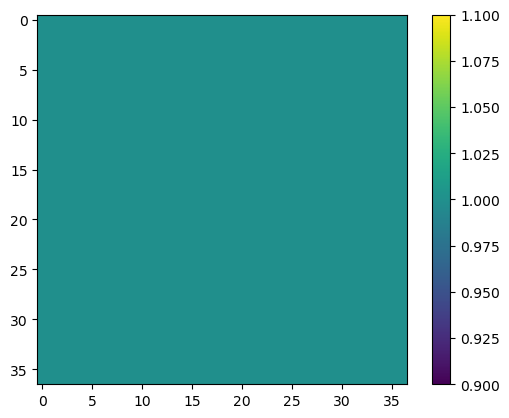

In [23]:
p0 = np.zeros((nx,ny,3)) + 1 # np.random.uniform(size=(nx,ny,3))
def dpdt(p, t, tmask, phi0, phi1, gamma0, gamma1):
    p = p.reshape((nx,ny,2))
    dpdt = np.zeros_like(p)
    dpdt[:,:,0] = phi0 - gamma0 * p[:,:,0] #- km0 * p[:,:,0]
    dpdt[:,:,1] = phi1 - gamma1 * p[:,:,1] #- km1 * p[:,:,1]
    #dpdt[:,:,2] = km0 * p[:,:,0] - gamma * p[:,:,2]
    #dpdt[:,:,3] = km1 * p[:,:,1] - gamma * p[:,:,3]
    for c in range(2):
        cdpdt = dpdt[:,:,c]
        cdpdt[tmask==0] = 0
        dpdt[:,:,c] = cdpdt
    return dpdt.ravel()

plt.imshow(p0[:,:,0])
plt.colorbar()

In [24]:
from scipy.integrate import odeint

def hill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx)

def shill(x, K, n):
    return 0.5 + n * (x - K) / 4 / K - n * (x - K)**2 / 8 / K**2

def step(x, K):
    return (x > K) * 1

def hill2(x, K0, K1, n):
    return (x/K0)**n / (1 + (x/K0)**n + (x/K1)**n)    

def solve_gene_expression(u, alpha0, alpha1, beta0, beta1, gamma_fp0, gamma_fp1, K0, K1, n, h, ts):
    nt = len(ts)
    print(nt)
    t0 = int(ts[0] * dt)
    p0 = crop_im[int(t0 / 60 / 10),:,:,:]
    p = np.zeros((nt+1,nx,ny,2))
    p[0,:,:,0] = p0[:,:,0]
    p[0,:,:,1] = p0[:,:,1]
    #p[0,:,:,2] = p0[:,:,0]
    #p[0,:,:,3] = p0[:,:,1]
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[int(t0 / 60 / 10 + offset),:,:]>0 # crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10 + offset),:,:] # crop_edt[0,:,:]
        #phi0 = alpha0 * step(u[ti,:,:], K0) + beta0
        #phi1 = alpha1 * step(u[ti,:,:], K1) + beta1
        phi0 = alpha0 * hill(u[ti,:,:], K0, n) + beta0
        phi1 = alpha1 * hill(u[ti,:,:], K1, n) + beta1
        #phi0 = alpha0 # * u[ti,:,:] + beta0
        #phi1 = alpha1 # * u[ti,:,:] + beta1
        #ukm0 = km0 * hill(u[ti,:,:], K, n)
        #ukm1 = km1 * hill(u[ti,:,:], K, n)
        dp = dpdt(p[ti,:,:,:], t, tmask>8, phi0 * h, phi1 * h, gamma_fp0, gamma_fp1)
        p[ti+1,:,:,:] = p[ti,:,:,:] + dt * dp.reshape(nx,ny,2)
        mask[ti+1,:,:] = tmask
    pmask = np.zeros_like(p) + np.nan
    for c in range(2):
        cp = p[:,:,:,c]
        cpmask = pmask[:,:,:,c]
        cpmask[mask>0] = cp[mask>0]
        pmask[:,:,:,c] = cpmask
    return pmask

def solve_diffusion(kappa, gamma0, gamma1, u0, dx, dt, t0, ts):
    nt = len(ts)
    print(nt)
    u = np.zeros((nt+1,nx,ny))
    #u0 = np.zeros((nx,ny)) + 1
    u[0,:,:] = u0
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10),:,:] # crop_edt[0,:,:]
        du = dudt(u[ti,:,:], t, tmask>8, 0, kappa, gamma0, gamma1, dx, t0)
        u[ti+1,:,:] = u[ti,:,:] + dt * du.reshape(nx,ny)
        mask[ti+1,:,:] = tmask

    umask = np.zeros_like(u) + np.nan
    umask[mask>0] = u[mask>0]
    return umask



In [25]:
from scipy.signal import savgol_filter

def compute_rho(x, y, w=21):
    rho_01 = x / y # pmask[:,:,:,0] / pmask[:,:,:,1]
    #rho_02 = pmask[:,:,:,0] / pmask[:,:,:,2]
    #rho_12 = pmask[:,:,:,1] / pmask[:,:,:,2]

    lrho_01 = np.log(rho_01)
    dslrho_01 = savgol_filter(lrho_01, w, 3, deriv=1, axis=0)
    #lrho_02 = np.log(rho_02)
    #dslrho_02 = savgol_filter(lrho_02, w, 3, deriv=1, axis=0)
    #lrho_12 = np.log(rho_12)
    #dslrho_12 = savgol_filter(lrho_12, w, 3, deriv=1, axis=0)

    #return rho_01,rho_02,rho_12, dslrho_01,dslrho_02,dslrho_12
    return rho_01,dslrho_01
    

In [26]:
from scipy.interpolate import interp1d

def residuals(x):
    print(np.exp(x))
    ha,gamma_fp0,gamma_fp1,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = np.exp(x)
    #gamma_fp = np.log(2) / (12 * 60 * 60)
    #umask,pmask = solve(alpha0, alpha1, alpha2, beta0, beta1, beta2, kappa, gamma, dx, dt, ts)
    ts = np.arange(0, np.floor(32 * 60 * 60 / dt + offset * 10 * 60 / dt))
    umask = solve_diffusion(kappa, gamma, 0, u0, dx, dt, t0, ts)
    uu = umask[:-1,:,:]
    ts2 = np.arange(np.floor(12 * 60 * 60 // dt), np.floor(32 * 60 * 60 // dt))

    idx0 = int(12 * 60 * 60 // dt // 120)
    print(idx0)
    #resid = p - crop_im[idx0:144,:,:,:]
    tidx0 = idx0
    tidx1 = int(32 * 60 * 60 // dt // 120)
    r = crop_edt[tidx0+int(offset),:,:]
    rr = r / crop_edt.max()
    #x0,x1,C = ha,1,-hb
    #h = C * rr * rr * rr + (-2 * C + x0 - x1) * rr * rr + (C - 2 * (x0 - x1)) * rr + x0
    sigma = ha
    h = np.exp(-(rr-1)**2/sigma)
    h = (h - h.min()) / (h.max() - h.min())
    h[r<0] = 0
    print(f'max(h),min(h) = {np.nanmin(h), np.nanmax(h)}')
    pmask = solve_gene_expression(uu[ts >= 12 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:], alpha0, alpha1, beta0, beta1, gamma_fp0, gamma_fp1, K0, K1, n, h, ts2)

    print(np.nanmin(pmask))
    print(pmask.shape)
    p = pmask[:-1:120,:,:,:]
    
    print(p.shape)
    cx = int(nx//2)
    cy = int(ny//2)
    #model = p[20:,:,:,:] # [:,cx-4:cx+4,cy-4:cy+4,:] # [:,int(nx//2),int(ny//2)-4,:]
    model = p
    print(f'Min model = {np.nanmin(model)}')
    #data = crop_im[tidx0+20:tidx1,:,:,:2] # cx-4:cx+4,cy-4:cy+4,:2]
    data = crop_im[tidx0:tidx1,:,:,:2] # cx-4:cx+4,cy-4:cy+4,:2]
    print(f'Min data = {np.nanmin(data)}')
    resid_data = (model - data) # / data
    resid_data[:,:,:,0] = resid_data[:,:,:,0] / np.nanmean(data[:,:,:,0])
    resid_data[:,:,:,1] = resid_data[:,:,:,1] / np.nanmean(data[:,:,:,1])
    resid = resid_data
    idx = np.isfinite(resid)
    resid = resid[idx]
    mse = np.mean(resid*resid)
    print(f'mse = {mse}')
    return resid
    #return mse

In [27]:
from scipy.optimize import least_squares, fmin

kappa = 1e-14
gamma = 1
t0 = 6 * 60 * 60
dx = 16e-6
dt = 5
alpha0,alpha1 = 1,1
beta0,beta1 = 1e-2,1e-2
K0,K1 = 1,1
K = 1
n = 2
km0,km1 = 1e-3,1e-4
ha,hb = 1,0.5
rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])  

#dlydt = savgol_filter(np.log(crop_im), 21, 3, axis=0, deriv=1)

#alpha0,alpha1,beta0,beta1,kappa,gamma = [3.24290426e+04, 9.97564949e+00, 1.03828550e-01, 8.33805001e-02, 1e-14, 1.86360254e+01]
#alpha0,kappa,gamma,K0,K1,n = np.load('xopt_pAAA.npy')
#gamma_fp,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = np.load('xopt_pAAA_fit_p_test_square.npy')
#ha, hb, gamma_fp,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = np.load('xopt_pAAA_fit_p.npy')

#ha, gamma_fp,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = np.load('xopt_pAAA_fit_p_gaussian_h_bg_corr.npy')
#ha, alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}_testing.npy')

ha,gamma_fp0,gamma_fp1,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}_testing.npy')

gamma_fp = np.log(2) / (12 * 60 * 60)
#gamma0 = gamma
#gamma1 = 1e-6
u0 = 1
#ha = 0.5

lb = [1e-6, 1e-8, 1e-8, 1e-6, 1e-6, 1e-6, 1e-6, 1e-16, 1e-6, 1e-6, 1e-6, 1]
ub = [1e6, 1, 1, 1e6, 1e6, 1e6, 1e6, 1e-12, 1e6, 1e6, 1e6, 100]
bounds = np.log([lb,ub])
res = least_squares(residuals, np.log([ha,gamma_fp0,gamma_fp1,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n]), bounds=bounds, ftol=1e-3)
#xopt = fmin(residuals, np.log([alpha1,beta,kappa,gamma,gamma_fp,t0]))

[2.96916826e-01 3.18017814e-04 7.33651101e-06 9.80106689e+00
 7.73960317e-06 5.33629986e-01 1.69524577e-03 1.33287486e-13
 9.35235888e+00 4.30419126e-01 2.52363520e+00 2.21560442e+01]
28499
72
max(h),min(h) = (0.0, 1.0)
14400
9.064675881208341
(14401, 37, 37, 2)
(120, 37, 37, 2)
Min model = 9.064675881208341
Min data = 6.555283400985322
mse = 0.01783470843596332
[2.96916821e-01 3.18017814e-04 7.33651101e-06 9.80106689e+00
 7.73960317e-06 5.33629986e-01 1.69524577e-03 1.33287486e-13
 9.35235888e+00 4.30419126e-01 2.52363520e+00 2.21560442e+01]
28499
72
max(h),min(h) = (0.0, 1.0)
14400
9.064675881208341
(14401, 37, 37, 2)
(120, 37, 37, 2)
Min model = 9.064675881208341
Min data = 6.555283400985322
mse = 0.017834709111836215
[2.96916826e-01 3.18017776e-04 7.33651101e-06 9.80106689e+00
 7.73960317e-06 5.33629986e-01 1.69524577e-03 1.33287486e-13
 9.35235888e+00 4.30419126e-01 2.52363520e+00 2.21560442e+01]
28499
72
max(h),min(h) = (0.0, 1.0)
14400
9.064675881208341
(14401, 37, 37, 2)
(120, 

In [28]:
res

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 0.000e+00  0.000e+00 ... -4.261e-02 -7.678e-02]
           x: [-1.202e+00 -8.066e+00 -1.182e+01  2.296e+00 -1.177e+01
               -6.271e-01 -6.380e+00 -2.965e+01  2.236e+00 -8.394e-01
                9.257e-01  3.098e+00]
        cost: 752.2929208878401
         jac: [[-0.000e+00 -0.000e+00 ...  0.000e+00  0.000e+00]
               [-0.000e+00 -0.000e+00 ...  0.000e+00  0.000e+00]
               ...
               [-0.000e+00 -0.000e+00 ...  0.000e+00  0.000e+00]
               [-0.000e+00 -0.000e+00 ...  0.000e+00  0.000e+00]]
        grad: [-1.703e+02  5.476e+01  5.270e+01 -4.481e+01  0.000e+00
               -9.534e+00 -1.506e+01  3.522e+00  1.748e+01  8.734e+00
                0.000e+00  3.841e+01]
  optimality: 2557.08058340555
 active_mask: [0 0 0 0 0 0 0 0 0 0 0 0]
        nfev: 5
        njev: 5

In [29]:
np.save(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}.npy', np.exp(res.x))

In [30]:
x = np.exp(res.x)
#x = np.load('xopt_pAAA.npy')
ha,gamma_fp0,gamma_fp1,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = x
#umask,pmask = solve(alpha0, alpha1, alpha2, beta0, beta1, beta2, kappa, gamma, dx, dt, ts)
ts = np.arange(0, np.floor(32 * 60 * 60 / dt + offset * 10 * 60 / dt))
umask = solve_diffusion(kappa, gamma, 0, u0, dx, dt, t0, ts)
uu = umask[:-1,:,:]
ts2 = np.arange(np.floor(12 * 60 * 60 // dt), np.floor(32 * 60 * 60 // dt))

idx0 = int(12 * 60 * 60 // dt // 120)
print(idx0)
#resid = p - crop_im[idx0:144,:,:,:]
tidx0 = idx0
tidx1 = int(32 * 60 * 60 // dt // 120)
r = crop_edt[tidx0+int(offset),:,:]
rr = r / crop_edt.max()
sigma = ha
h = np.exp(-(rr-1)**2/sigma)
h = (h - h.min()) / (h.max() - h.min())
h[r<0] = 0
print(f'max(h),min(h) = {np.nanmin(h), np.nanmax(h)}')
pmask = solve_gene_expression(uu[ts >= 12 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:], alpha0, alpha1, beta0, beta1, gamma_fp0, gamma_fp1, K0, K1, n, h, ts2)

print(np.nanmin(pmask))
print(pmask.shape)
p = pmask[:-1:120,:,:,:]
mrho, mdslrho = compute_rho(p[:,:,:,0], p[:,:,:,1]) 
rho_01,dslrho_01 = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1]) 

28499
72
max(h),min(h) = (0.0, 1.0)
14400
9.064675881208341
(14401, 37, 37, 2)


In [31]:
np.save(os.path.join(path_results,'diff_pmask.npy'),pmask) # solution for gene expression
np.save(os.path.join(path_results,'diff_p.npy'),p) # p = pmask[:-1:120,:,:,:]
np.save(os.path.join(path_results,'diff_umask.npy'),umask) # solution for dilution
np.save(os.path.join(path_results,'diff_uu.npy'),uu) # uu = umask[:-1,:,:]
np.save(os.path.join(path_results,'diff_mrho.npy'),mrho) # model
np.save(os.path.join(path_results,'diff_mdslrho.npy'),mdslrho) # model
np.save(os.path.join(path_results,'diff_rho_01.npy'),rho_01) # data
np.save(os.path.join(path_results,'diff_dslrho_01.npy'),dslrho_01) # data

Text(0, 0.5, 'Position (pixels)')

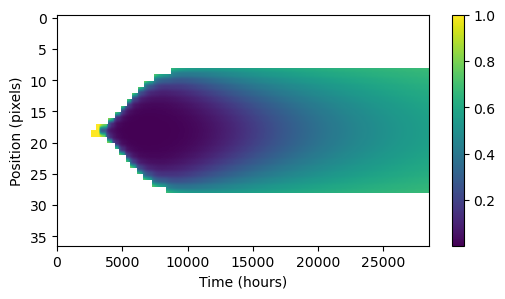

In [32]:
plt.figure(figsize=(6,3))
plt.imshow(umask[:,int(nx//2),:].transpose(), aspect='auto') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()
#plt.contour(u[10:,int(nx//2),:].transpose(), [0.025])
plt.xlabel('Time (hours)')
plt.ylabel('Position (pixels)')

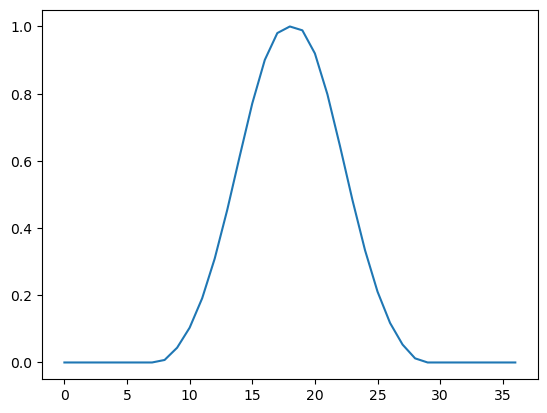

In [33]:
plt.plot(h[int(nx//2),:])
#plt.colorbar()

In [77]:
#np.save(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}_testing.npy', x)

In [30]:
## FROM FILE
x = np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}.npy')
# p = np.load()
# crop_im = np.load()

In [34]:
ha, gamma_fp0, gamma_fp1, alpha0, alpha1, beta0, beta1, kappa, gamma, K0, K1, n = x

# Print the parameter names along with their values
print(f"ha: {ha}")
print(f"gamma_fp: {gamma_fp0,gamma_fp1}")
print(f"alpha0: {alpha0}")
print(f"alpha1: {alpha1}")
print(f"beta0: {beta0}")
print(f"beta1: {beta1}")
print(f"kappa: {kappa}")
print(f"gamma: {gamma}")
print(f"K0: {K0}")
print(f"K1: {K1}")
print(f"n: {n}")
print(f'FP0 half life = {np.log(2) / gamma_fp0 / 60} mins')
print(f'FP1 half life = {np.log(2) / gamma_fp1 / 60 / 60} hrs')

ha: 0.3005487208499576
gamma_fp: (0.0003140942844571117, 7.334065439497135e-06)
alpha0: 9.929595564813585
alpha1: 7.739603173221354e-06
beta0: 0.534112403920825
beta1: 0.0016957449364757519
kappa: 1.3306329920905802e-13
gamma: 9.360250000575292
K0: 0.431963986972776
K1: 2.5236351991868795
n: 22.157277569340586
FP0 half life = 36.78020766694296 mins
FP1 half life = 26.252954119001615 hrs


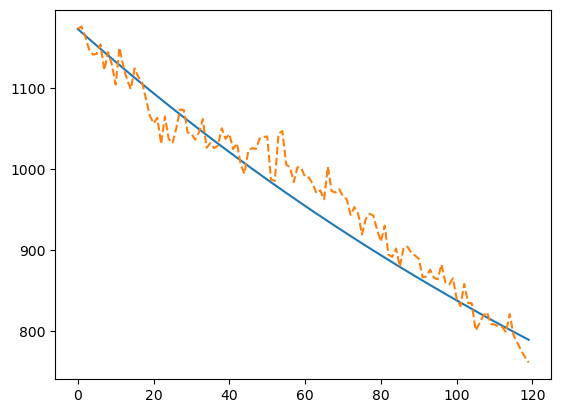

In [35]:
plt.plot(p[:,int(nx//2),int(ny//2),1]) #, aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.plot(crop_im[tidx0:tidx1,int(nx//2),int(ny//2),1], '--') # , aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
#plt.colorbar()

/home/guillermo/anaconda3/envs/popdyn/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


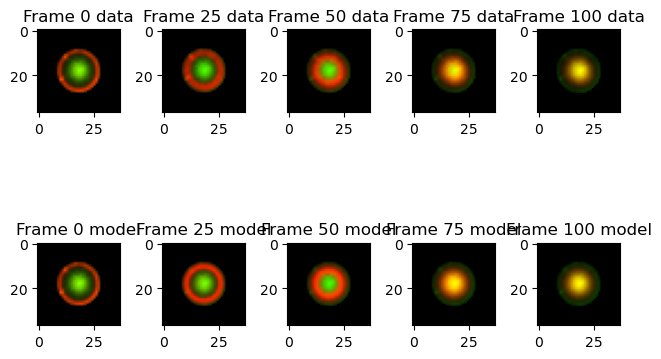

In [36]:
tidxs = [0, 25, 50, 75, 100]
ntidx = len(tidxs)
fig,axs = plt.subplots(2, ntidx)
for i in range(ntidx):
    tidx = tidxs[i]

    cim = np.zeros((nx,ny,3))
    cim1 = crop_im[idx0+tidx,:,:,0]
    cim1 = (cim1 - np.nanmin(cim1)) / (np.nanmax(cim1) - np.nanmin(cim1))
    cim2 = crop_im[idx0+tidx,:,:,1]
    cim2 = (cim2 - np.nanmin(cim2)) / (np.nanmax(cim2) - np.nanmin(cim2))
    cim[:,:,0] = cim1
    cim[:,:,1] = cim2
    axs[0,i].imshow(cim, aspect='equal')
    axs[0,i].set_title(f'Frame {tidx} data')

    cim = np.zeros((nx,ny,3))
    cim1 = p[tidx,:,:,0]
    cim1 = (cim1 - np.nanmin(cim1)) / (np.nanmax(cim1) - np.nanmin(cim1))
    cim2 = p[tidx,:,:,1]
    cim2 = (cim2 - np.nanmin(cim2)) / (np.nanmax(cim2) - np.nanmin(cim2))
    cim[:,:,0] = cim1
    cim[:,:,1] = cim2
    axs[1,i].imshow(cim, aspect='equal')
    axs[1,i].set_title(f'Frame {tidx} model')
plt.tight_layout()

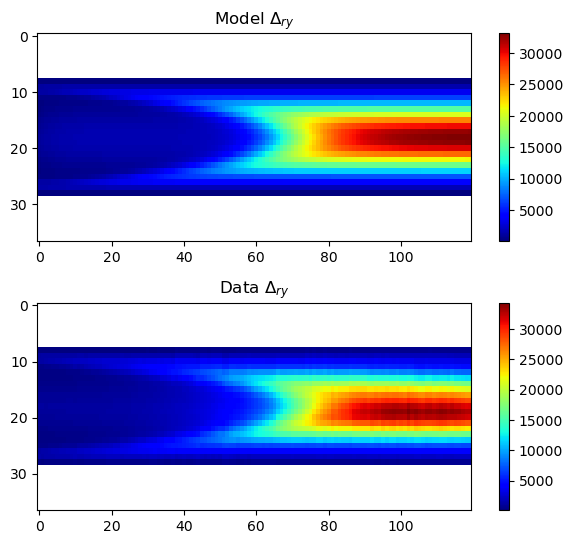

In [37]:
plt.figure(figsize=(6,8))

idx0 = int(12 * 60 * 60 // dt // 120)
idx1 = int(32 * 60 * 60 // dt // 120)

plt.subplot(3,1,1)
plt.imshow(p[:,int(nx//2),:,0].transpose(), aspect='auto', cmap='jet') #, vmin=-0.1, vmax=0.1) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.title('Model $\Delta_{ry}$')
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(crop_im[idx0:idx1,int(nx//2),:,0].transpose(), aspect='auto', cmap='jet') #, vmin=-0.1, vmax=0.1) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.title('Data $\Delta_{ry}$')
plt.colorbar()

plt.tight_layout()

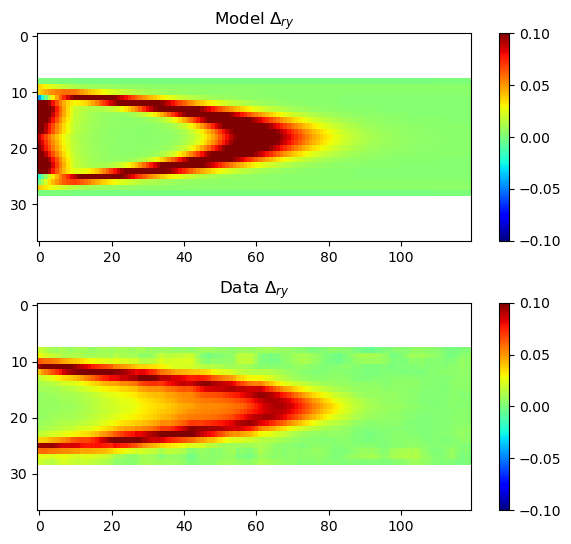

In [38]:
plt.figure(figsize=(6,8))

idx0 = int(12 * 60 * 60 // dt // 120) # when start after growth rate
idx1 = int(32 * 60 * 60 // dt // 120) # when wave arrives

plt.subplot(3,1,1)
plt.imshow(mdslrho[:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.1, vmax=0.1) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
#plt.imshow(mdslrho[20:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.1, vmax=0.1) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.title('Model $\Delta_{ry}$')
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(dslrho_01[idx0:idx1,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.1, vmax=0.1) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
#plt.imshow(dslrho_01[idx0+20:idx1,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.1, vmax=0.1) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.title('Data $\Delta_{ry}$')
plt.colorbar()

plt.tight_layout()

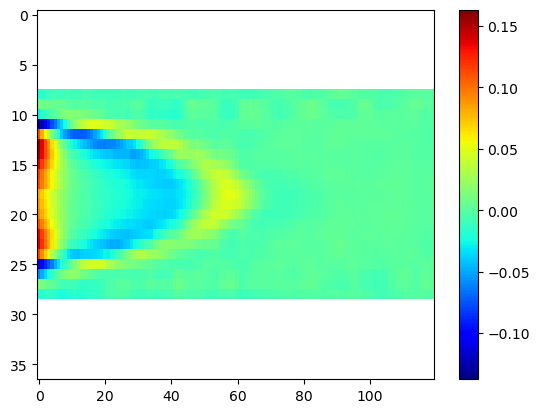

In [41]:
#err01 = mdslrho[:,int(nx//2),:] - dslrho_01[idx0+20:idx1,int(nx//2),:]
err01 = mdslrho[:,int(nx//2),:] - dslrho_01[idx0:idx1,int(nx//2),:]

plt.imshow(err01.transpose(), aspect='auto', cmap='jet')
plt.colorbar()

In [72]:
ha,gamma_fp0,gamma_fp1,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}.npy')

# Print the parameter names along with their values
print(f"ha: {ha}")
print(f"gamma_fp: {gamma_fp0,gamma_fp1}")
print(f"alpha0: {alpha0}")
print(f"alpha1: {alpha1}")
print(f"beta0: {beta0}")
print(f"beta1: {beta1}")
print(f"kappa: {kappa}")
print(f"gamma: {gamma}")
print(f"K0: {K0}")
print(f"K1: {K1}")
print(f"n: {n}")
print(f'FP0 half life = {np.log(2) / gamma_fp0 / 60} mins')
print(f'FP1 half life = {np.log(2) / gamma_fp1 / 60 / 60} hrs')

ha: 0.3005487208499576
gamma_fp: (0.0003140942844571117, 7.334065439497135e-06)
alpha0: 9.929595564813585
alpha1: 7.739603173221354e-06
beta0: 0.534112403920825
beta1: 0.0016957449364757519
kappa: 1.3306329920905802e-13
gamma: 9.360250000575292
K0: 0.431963986972776
K1: 2.5236351991868795
n: 22.157277569340586
FP0 half life = 36.78020766694296 mins
FP1 half life = 26.252954119001615 hrs


#### From file

In [ ]:
## blocks are 16 pixels

In [5]:
#path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
#path_ext = '/Volumes/Expansion/Thesis GY/3. Analyzed files'
path_ext = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
folder_results = 'results'
folder_velocity = 'velocity_data'

scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}

In [6]:
exp_date = '2023_11_30'
vector = 'pAAA'
#vector = 'pLPT107&pLPT41'
#vector = 'pLPT20&pLPT41'
#vector = 'pLPT119&pLPT41'

#scope_name = 'Ti scope'
scope_name = 'Tweez scope'
pos = 15

path_scope = os.path.join(path_ext, scope_name)
path = os.path.join(path_scope, exp_date)
path_results = os.path.join(path,folder_results, f"pos{pos}")
path_velocity = os.path.join(path,folder_velocity, f"pos{pos}")

fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
fname

'2023_11_30_10x_1.0x_pAAA_TiTweez_Pos15.ome.tif'

In [7]:
if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

In [8]:
area_all = np.load(os.path.join(path_results,'diff_area_all.npy')) # area
pmask = np.load(os.path.join(path_results,'diff_pmask.npy')) # solution for gene expression
p = np.load(os.path.join(path_results,'diff_p.npy')) # p = pmask[:-1:120,:,:,:]
umask = np.load(os.path.join(path_results,'diff_umask.npy')) # solution for dilution
uu = np.load(os.path.join(path_results,'diff_uu.npy')) # uu = umask[:-1,:,:]
mrho = np.load(os.path.join(path_results,'diff_mrho.npy')) # model
mdslrho = np.load(os.path.join(path_results,'diff_mdslrho.npy')) # model
rho_01 = np.load(os.path.join(path_results,'diff_rho_01.npy')) # data
dslrho_01 = np.load(os.path.join(path_results,'diff_dslrho_01.npy')) # data
crop_edt = np.load(os.path.join(path_results, 'diff_crop_edt.npy'))
crop_im = np.load(os.path.join(path_results, 'diff_crop_im.npy'))

In [9]:
ntt,nx,ny = crop_edt.shape
nt,nx,ny,nc = crop_im.shape
dt = 5

In [10]:
## better doing it loading the radius
edt = np.load(os.path.join(path_results,'edt.npy'))

In [11]:
ylim = (edt.max() + 16) * 1.35
ylim

242.1959485122064

#### Diffusion solution

In [19]:
def plot_diffusion(ylim, area_all, shift, umask, nx,ymin, ymax, rad_shift,filename, tfin):
    ## GET THE SHIFT CORRECT !
    plt.figure(figsize=(9,4.2))
    #ylim = (edt.max() + 16) * 1.35
    rad_blocks = np.sqrt(area_all / np.pi) / 16
    #shift = 0
    tf = umask[shift:, int(nx // 2), ymin:ymax].shape[0]
    
    # Plot the image
    plt.imshow(umask[shift:, int(nx // 2), ymin:ymax].transpose(), aspect='auto', cmap='jet',vmin=0, vmax=1)
    
    # Plot the overlaid lines
    plt.plot(np.linspace(0, tf, num=len(rad_blocks)), rad_blocks + rad_shift, '--k')
    plt.plot(np.linspace(0, tf, num=len(rad_blocks)), -rad_blocks + rad_shift, '--k')
    
    # Add the colorbar
    plt.colorbar()
    
    # Add title and labels with the specified font sizes
    plt.title('Diffusion field solution', fontsize=18)  # Title with fontsize 18
    plt.xlabel('Time [h]', fontsize=16)  # X label fontsize 14
    plt.ylabel('Radial distance [$\mu m$]', fontsize=16)  # Y label fontsize 14
    
    # Set the y-tick positions and labels to limit the number of points shown
    ytick_positions = np.linspace(0, umask[shift:, int(nx // 2), ymin:ymax].shape[1]-1, num=5)  # Limit to 5 ticks
    
    plt.yticks(ytick_positions, labels=np.linspace(-ylim, ylim, num=5).astype(int), fontsize=16)  # Set labels and fontsize 14 for y-ticks
    plt.gca().invert_yaxis()
    # Now set the x-ticks correctly
    # Calculate the time shift in hours
    time_shift_hours = (shift * dt) / 3600
    
    # Set the xtick positions to match the pixel positions
    xtick_positions = np.linspace(0, tf, num=6)  # Generate tick positions based on the pixel index range
    xtick_labels = np.linspace(time_shift_hours, tfin, num=6, dtype=int)  # Set labels from time shift to 32 hours
    
    plt.xticks(xtick_positions, labels=xtick_labels, fontsize=16)  # Apply the tick positions and labels, fontsize 14 for x-ticks
    
    # Set the x-axis limits to match the range of the data (prevent extra white space)
    plt.xlim(0, tf)  # Restrict x-axis to the data range
    
    plt.tight_layout()
    plt.savefig(filename,dpi=300)
    plt.show()

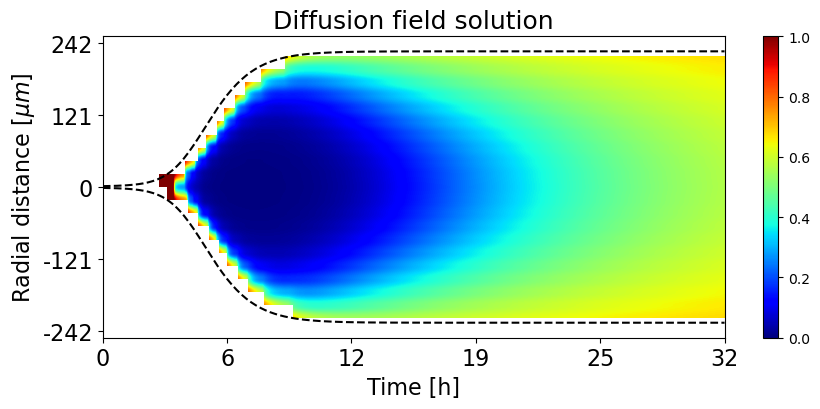

In [65]:
# pAAA
ymin = 7
ymax=30
rad_shift = 11
shift = 0
filename = 'pAAA_diff_field.png'
tfin = 32

plot_diffusion(ylim, area_all, shift, umask, nx, ymin, ymax, rad_shift,filename, tfin)

#### Model - Data time lapse plots

In [12]:
incubation_time = 7.5833 * 60 * 60
offset = incubation_time / 60 / 10
idx0 = int(12 * 60 * 60 // dt // 120) # when start after growth rate
idx1 = int(32 * 60 * 60 // dt // 120) # when wave arrives
tini = 12

/Users/guillermo/anaconda3/envs/popdyn/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


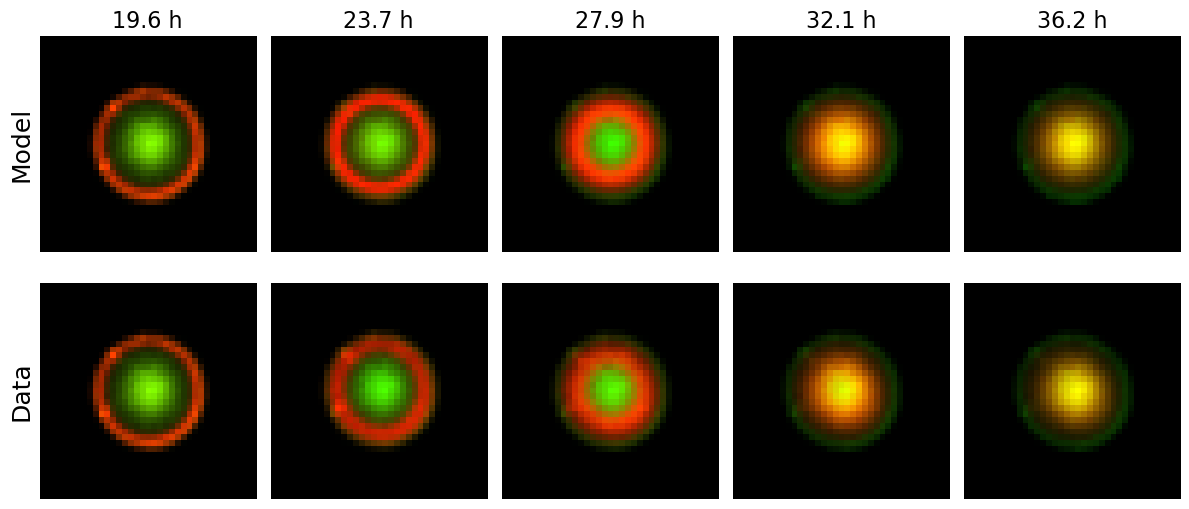

In [21]:
tidxs = [0, 25, 50, 75, 100]
ntidx = len(tidxs)
fig, axs = plt.subplots(2, ntidx, figsize=(12, 8))

for i in range(ntidx):
    tidx = tidxs[i]
    hours = incubation_time / 60 / 60 + tini + tidx * 10 / 60 

    # Model data
    cim = np.zeros((nx,ny,3))
    cim1 = p[tidx,:,:,0]
    cim1 = (cim1 - np.nanmin(cim1)) / (np.nanmax(cim1) - np.nanmin(cim1))
    cim2 = p[tidx,:,:,1]
    cim2 = (cim2 - np.nanmin(cim2)) / (np.nanmax(cim2) - np.nanmin(cim2))
    cim[:,:,0] = cim1
    cim[:,:,1] = cim2
    axs[0,i].imshow(cim, aspect='equal')
    axs[0,i].set_title(f'{round(hours, 1)} h', fontsize=16)

    # Data
    cim = np.zeros((nx,ny,3))
    cim1 = crop_im[idx0+tidx,:,:,0]
    cim1 = (cim1 - np.nanmin(cim1)) / (np.nanmax(cim1) - np.nanmin(cim1))
    cim2 = crop_im[idx0+tidx,:,:,1]
    cim2 = (cim2 - np.nanmin(cim2)) / (np.nanmax(cim2) - np.nanmin(cim2))
    cim[:,:,0] = cim1
    cim[:,:,1] = cim2
    axs[1,i].imshow(cim, aspect='equal')
    #axs[1,i].set_title(f'{round(hours, 1)} h')

    # Remove ticks and spines for a cleaner look
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[0,i].spines['top'].set_visible(False)
    axs[0,i].spines['bottom'].set_visible(False)
    axs[0,i].spines['left'].set_visible(False)
    axs[0,i].spines['right'].set_visible(False)
    
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[1,i].spines['top'].set_visible(False)
    axs[1,i].spines['bottom'].set_visible(False)
    axs[1,i].spines['left'].set_visible(False)
    axs[1,i].spines['right'].set_visible(False)

# Add y-axis labels only for the first subplot in each row
axs[0, 0].set_ylabel('Model', fontsize=18)
axs[1, 0].set_ylabel('Data', fontsize=18)

# Adjust layout to reduce spaces between the subplots
plt.subplots_adjust(wspace=80, hspace=0.1)

# Call tight_layout to ensure proper spacing
plt.tight_layout()
plt.savefig('pAAA_fluo_model_data.png', bbox_inches='tight')

##### Videos

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Create folders for storing images
model_folder = "pAAA_model"
data_folder = "pAAA_data"

os.makedirs(model_folder, exist_ok=True)
os.makedirs(data_folder, exist_ok=True)

# Number of time steps in the arrays
nt = p.shape[0]  # Assuming the first dimension of `p` represents time

for t in range(nt):
    print(f"Processing time step: {t}")

    # Model data
    cim = np.zeros((nx, ny, 3))
    cim1 = p[t, :, :, 0]
    cim1 = (cim1 - np.nanmin(cim1)) / (np.nanmax(cim1) - np.nanmin(cim1))
    cim2 = p[t, :, :, 1]
    cim2 = (cim2 - np.nanmin(cim2)) / (np.nanmax(cim2) - np.nanmin(cim2))
    cim[:, :, 0] = cim1
    cim[:, :, 1] = cim2

    # Save the model image
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cim, aspect='equal')

    # Remove ticks and spines for a cleaner look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout(pad=0)
    plt.savefig(os.path.join(model_folder, f"model_{t:03d}.png"), bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

    # Data
    cim = np.zeros((nx, ny, 3))
    cim1 = crop_im[idx0 + t, :, :, 0]
    cim1 = (cim1 - np.nanmin(cim1)) / (np.nanmax(cim1) - np.nanmin(cim1))
    cim2 = crop_im[idx0 + t, :, :, 1]
    cim2 = (cim2 - np.nanmin(cim2)) / (np.nanmax(cim2) - np.nanmin(cim2))
    cim[:, :, 0] = cim1
    cim[:, :, 1] = cim2

    # Save the data image
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cim, aspect='equal')

    # Remove ticks and spines for a cleaner look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout(pad=0)
    plt.savefig(os.path.join(data_folder, f"data_{t:03d}.png"), bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()


Processing time step: 0


/Users/guillermo/anaconda3/envs/popdyn/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


Processing time step: 1
Processing time step: 2
Processing time step: 3
Processing time step: 4
Processing time step: 5
Processing time step: 6
Processing time step: 7
Processing time step: 8
Processing time step: 9
Processing time step: 10
Processing time step: 11
Processing time step: 12
Processing time step: 13
Processing time step: 14
Processing time step: 15
Processing time step: 16
Processing time step: 17
Processing time step: 18
Processing time step: 19
Processing time step: 20
Processing time step: 21
Processing time step: 22
Processing time step: 23
Processing time step: 24
Processing time step: 25
Processing time step: 26
Processing time step: 27
Processing time step: 28
Processing time step: 29
Processing time step: 30
Processing time step: 31
Processing time step: 32
Processing time step: 33
Processing time step: 34
Processing time step: 35
Processing time step: 36
Processing time step: 37
Processing time step: 38
Processing time step: 39
Processing time step: 40
Processin

#### Make kymos

#### Kymo Data

In [17]:
im_all = crop_im[:,:,:,0]
# Assuming im_all is your image stack of shape (216, 37, 37)
nt, nx, ny = im_all.shape

# Calculate the radial distances for all pixels from the center of the image
x_center = nx // 2
y_center = ny // 2
y, x = np.ogrid[:ny, :nx]
radii = np.sqrt((x - x_center)**2 + (y - y_center)**2)

# Define the radial bands (you can adjust the range if needed)
rs = np.arange(1, 19)  # Radial distances (from 1 to 18)

# Initialize an array to store the mean intensity for each band over time
imrmean = np.zeros((nt, len(rs))) + np.nan

# Loop over each time point and calculate the mean for each radial band
for t in range(nt):
    for i, r in enumerate(rs):
        # Get the pixels that fall within the current radial band
        mask = (radii >= r - 0.5) & (radii < r + 0.5)
        
        # Extract the corresponding pixel values from the image
        pixels_in_band = im_all[t, mask]
        
        # Calculate the mean for the radial band, ignoring NaNs
        if len(pixels_in_band) > 0:
            imrmean[t, i] = np.nanmean(pixels_in_band)

# Now, rmean contains the kymograph: time (216) by radial distance (19)

/tmp/ipykernel_76226/1995091814.py:28: RuntimeWarning: Mean of empty slice
  imrmean[t, i] = np.nanmean(pixels_in_band)


#### Kymo Model

In [18]:
im_all = pmask[:,:,:,0]
nt,nx,ny = im_all.shape
# Assuming im_all is your image stack of shape (216, 37, 37)
nt = 192

# Calculate the radial distances for all pixels from the center of the image
x_center = nx // 2
y_center = ny // 2
y, x = np.ogrid[:ny, :nx]
radii = np.sqrt((x - x_center)**2 + (y - y_center)**2)

# Define the radial bands (you can adjust the range if needed)
rs = np.arange(1, 19)  # Radial distances (from 1 to 18)

# Initialize an array to store the mean intensity for each band over time
mrmean = np.zeros((nt, len(rs))) + np.nan

# Loop over each time point and calculate the mean for each radial band

tbase = 72
tim = 100

for tim in range(tbase,nt):
    tmodel = (tim - tbase) * 120
    t = tmodel
    for i, r in enumerate(rs):
        # Get the pixels that fall within the current radial band
        mask = (radii >= r - 0.5) & (radii < r + 0.5)
        
        # Extract the corresponding pixel values from the image
        pixels_in_band = im_all[t, mask]
        
        # Calculate the mean for the radial band, ignoring NaNs
        if len(pixels_in_band) > 0:
            mrmean[tim, i] = np.nanmean(pixels_in_band)

# Now, rmean contains the kymograph: time (216) by radial distance (19)

/tmp/ipykernel_76226/1868392819.py:35: RuntimeWarning: Mean of empty slice
  mrmean[tim, i] = np.nanmean(pixels_in_band)


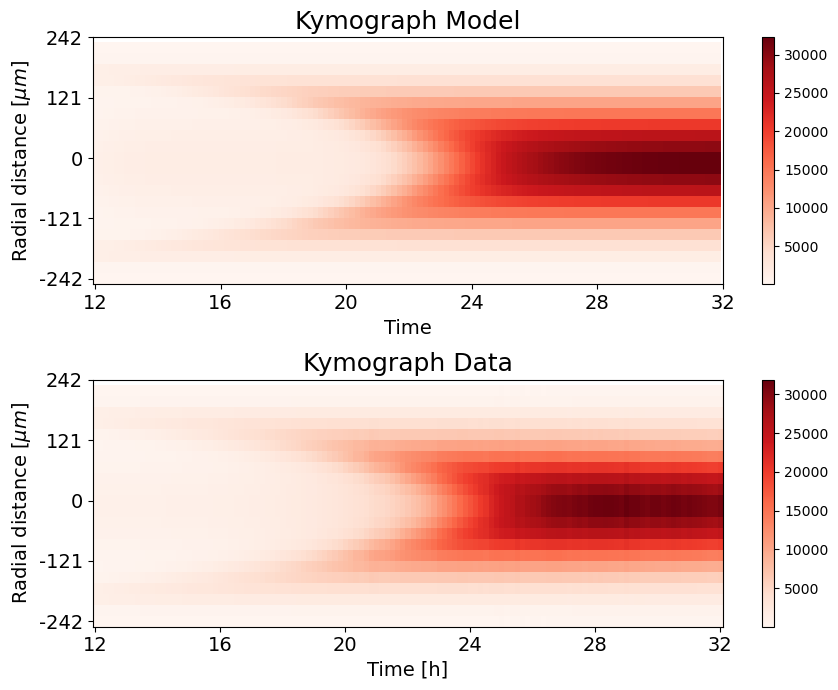

In [20]:
plt.figure(figsize=(9, 7))

# First subplot: Kymograph Model
plt.subplot(2, 1, 1)
mkymograph = np.hstack([mrmean[:, ::-1], mrmean[:, :]])
plt.imshow(mkymograph.T[7:29, 72:], aspect='auto', cmap='Reds')
plt.title('Kymograph Model', fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Radial distance [$\mu m$]', fontsize=14)
plt.colorbar()
#plt.xticks([])  # Remove x-ticks for the top plot
plt.xticks(xtick_positions, labels=xtick_labels, fontsize=14)  # X-ticks with fontsize 14
plt.yticks(np.linspace(0, mdslrho[:, int(nx // 2), 7:29].shape[1], num=5), labels=np.linspace(-ylim, ylim, num=5).astype(int), fontsize=14)
plt.gca().invert_yaxis()  # Invert the y-axis

# Second subplot: Kymograph Image
plt.subplot(2, 1, 2)
imkymograph = np.hstack([imrmean[:193, ::-1], imrmean[:193, :]])
plt.imshow(imkymograph.T[7:29, 72:], aspect='auto', cmap='Reds')
plt.title('Kymograph Data', fontsize=18)
#plt.xlabel('Time', fontsize=14)
#plt.ylabel('Radial Distance', fontsize=14)
plt.colorbar()

# Set the x-ticks and labels
xtick_positions = np.linspace(0, idx1 - idx0, num=6)  # Generate tick positions for the whole range
xtick_labels = np.linspace(12, 32, num=6, dtype=int)  # Adjust labels accordingly
plt.xticks(xtick_positions, labels=xtick_labels, fontsize=14)  # X-ticks with fontsize 14
plt.yticks(np.linspace(0, dslrho_01[idx0:idx1, int(nx // 2), 7:29].shape[1], num=5), labels=np.linspace(-ylim, ylim, num=5).astype(int), fontsize=14)  # Y-ticks using ylim, fontsize 14
plt.xlabel('Time [h]', fontsize=14)  # X-axis label font size 14
plt.ylabel('Radial distance [$\mu m$]', fontsize=14)  # Y-axis label font size 14
plt.gca().invert_yaxis()  # Invert the y-axis

plt.tight_layout()
plt.savefig('pAAA_kymo_fluo_model_data.png', bbox_inches='tight')

#### Delta computation

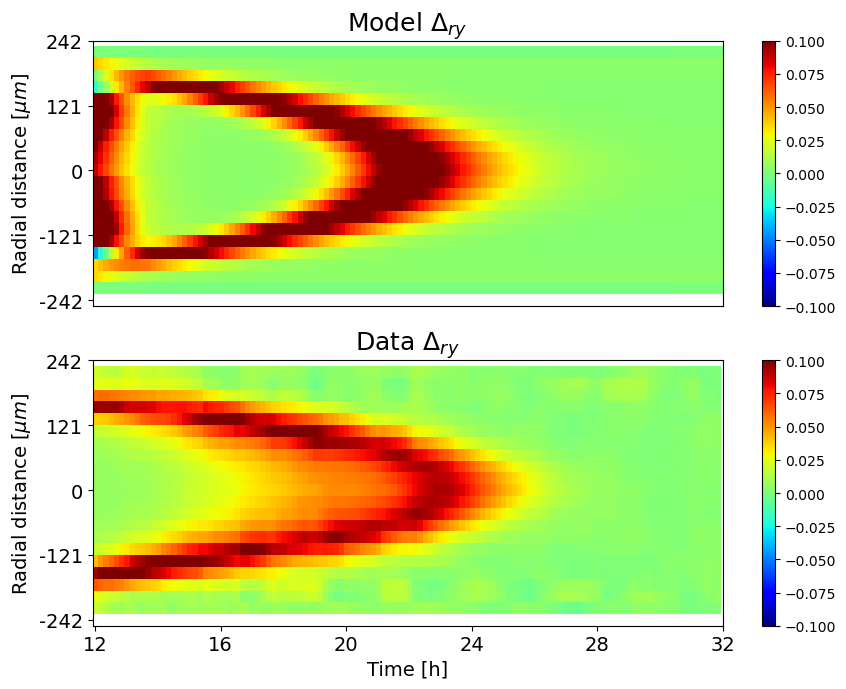

In [70]:
plt.figure(figsize=(9,7))
ylim = (edt.max() +16)* 1.35  # New ylim calculation

idx0 = int(12 * 60 * 60 // dt // 120)  # when start after growth rate
idx1 = int(32 * 60 * 60 // dt // 120)  # when wave arrives

# First subplot (Model)
plt.subplot(2, 1, 1)
plt.imshow(mdslrho[:, int(nx // 2), 7:29].transpose(), aspect='auto', cmap='jet', vmin=-0.1, vmax=0.1)
plt.title('Model $\Delta_{ry}$', fontsize=18)  # Title with fontsize 18
plt.colorbar()
plt.xticks([])  # Remove x-ticks for the top plot
plt.yticks(np.linspace(0, mdslrho[:, int(nx // 2), 7:29].shape[1], num=5), labels=np.linspace(-ylim, ylim, num=5).astype(int), fontsize=14)  # Y-ticks using ylim, fontsize 14
plt.ylabel('Radial distance [$\mu m$]', fontsize=14)  # Y-axis label font size 14
plt.gca().invert_yaxis()  # Invert the y-axis

# Second subplot (Data)
plt.subplot(2, 1, 2)
plt.imshow(dslrho_01[idx0:idx1, int(nx // 2), 7:29].transpose(), aspect='auto', cmap='jet', vmin=-0.1, vmax=0.1)
plt.title('Data $\Delta_{ry}$', fontsize=18)  # Title with fontsize 18
plt.colorbar()

# Set the x-ticks and labels
xtick_positions = np.linspace(0, idx1 - idx0, num=6)  # Generate tick positions for the whole range
xtick_labels = np.linspace(12, 32, num=6, dtype=int)  # Adjust labels accordingly
plt.xticks(xtick_positions, labels=xtick_labels, fontsize=14)  # X-ticks with fontsize 14
plt.yticks(np.linspace(0, dslrho_01[idx0:idx1, int(nx // 2), 7:29].shape[1], num=5), labels=np.linspace(-ylim, ylim, num=5).astype(int), fontsize=14)  # Y-ticks using ylim, fontsize 14
plt.xlabel('Time [h]', fontsize=14)  # X-axis label font size 14
plt.ylabel('Radial distance [$\mu m$]', fontsize=14)  # Y-axis label font size 14
plt.gca().invert_yaxis()  # Invert the y-axis

plt.tight_layout()
plt.savefig('pAAA_kymo_delta_model_data.png', bbox_inches='tight')


In [73]:
ha,gamma_fp0,gamma_fp1,alpha0,alpha1,beta0,beta1,kappa,gamma,K0,K1,n = np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}.npy')

# Print the parameter names along with their values
print(f"ha: {ha}")
print(f"gamma_fp: {gamma_fp0,gamma_fp1}")
print(f"alpha0: {alpha0}")
print(f"alpha1: {alpha1}")
print(f"beta0: {beta0}")
print(f"beta1: {beta1}")
print(f"kappa: {kappa}")
print(f"gamma: {gamma}")
print(f"K0: {K0}")
print(f"K1: {K1}")
print(f"n: {n}")
print(f'FP0 half life = {np.log(2) / gamma_fp0 / 60 / 60} hrs')
print(f'FP1 half life = {np.log(2) / gamma_fp1 / 60 / 60} hrs')

ha: 0.3005487208499576
gamma_fp: (0.0003140942844571117, 7.334065439497135e-06)
alpha0: 9.929595564813585
alpha1: 7.739603173221354e-06
beta0: 0.534112403920825
beta1: 0.0016957449364757519
kappa: 1.3306329920905802e-13
gamma: 9.360250000575292
K0: 0.431963986972776
K1: 2.5236351991868795
n: 22.157277569340586
FP0 half life = 0.6130034611157159 hrs
FP1 half life = 26.252954119001615 hrs
